In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from src.base_line import BaseLine
from src.read_params import read_params

### Симуляции спроса товара во времени
- Генерируются сезонные и трендовые составляющие
- Генерируется параметры функции спроса (эластичности)
- На каждый день, исходя из фактора тренда/сезонности и эластичности по закону Пуассона генерируется спрос

In [95]:
par1, par2, n_point, n_lev, trend, season_amp, season_fi, period = read_params(
    "src/params.yaml"
)
# Создаем экземпляр класса - ГЕНЕРИРУЕМ ДАННЫЕ ОДИН РАЗ
# Эти данные будут использоваться для всех дальнейших анализов
market = BaseLine(params=par1, # par1 - экспоенциальная эластичность, par2 - линейная экспонента
            num_point=250, # количество дней симуляции
            num_level=20, # количество ценовых уровней
            trend=trend,
            seasonality=(season_amp[0],season_amp[1], season_fi),
            period=365,
        )
# Сохраняем данные в переменные для использования во всех последующих ячейках
price = market.x.copy()  # копируем, чтобы не изменялись
order = market.order.copy()  # копируем, чтобы не изменялись

print(f"✓ Данные сгенерированы: {len(order)} дней")
print(f"  Объем продаж: min={order.min()}, max={order.max()}, mean={order.mean():.2f}")
print(f"  Цены: min={price.min():.3f}, max={price.max():.3f}, mean={price.mean():.3f}")
print(f"  Эти данные будут использоваться для всех дальнейших анализов")

✓ Данные сгенерированы: 250 дней
  Объем продаж: min=0, max=11, mean=3.35
  Цены: min=0.009, max=0.993, mean=0.460
  Эти данные будут использоваться для всех дальнейших анализов


Вывод графиков

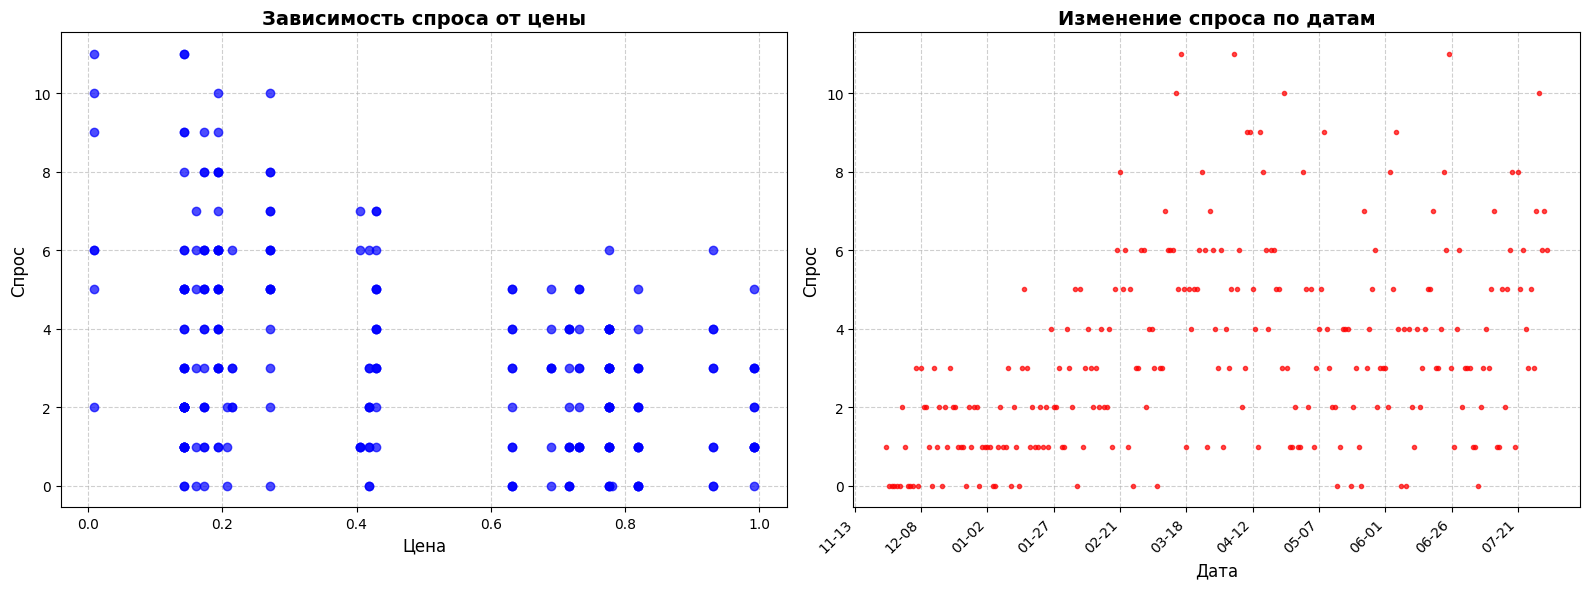

✓ Графики построены на основе данных из ячейки 3: 250 точек


In [96]:
# Используем данные из ячейки 3 (order и price)
# Определим количество точек данных
n_points = len(order)

# Массив дат
start_date = datetime.today()
dates = [start_date + timedelta(days=i) for i in range(n_points)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# График зависимости спроса от цены (используем данные из ячейки 3)
ax1.plot(price, order, 'o', color='blue', markersize=6, alpha=0.7, linewidth=1.5)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xlabel('Цена', fontsize=12)
ax1.set_ylabel('Спрос', fontsize=12)
ax1.set_title('Зависимость спроса от цены', fontsize=14, fontweight='bold')

# График изменения спроса по датам (используем данные из ячейки 3)
ax2.plot(dates, order, '.', color='red', markersize=6, alpha=0.7)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xlabel('Дата', fontsize=12)
ax2.set_ylabel('Спрос', fontsize=12)
ax2.set_title('Изменение спроса по датам', fontsize=14, fontweight='bold')

# Форматирование оси X 
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Формат: месяц-день
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, n_points // 10)))  # Показывать даты с разумным интервалом
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"✓ Графики построены на основе данных из ячейки 3: {n_points} точек")

## Прогнозирование объемов продаж на 30 дней

Используем 5 различных нейросетевых моделей для прогнозирования кумулятивной суммы продаж


In [97]:
# Импорты для прогнозирования
from src.utils.data_prep import to_cumulative, prepare_train_test
from src.utils.metrics import calculate_metrics, mae, rmse, mape, smape
from src.utils.visualization import (
    plot_single_method, 
    plot_prediction_comparison, 
    plot_all_methods_comparison
)
from src.models import (
    ChronosModel, 
    TimesFMModel, 
    PatchTSTModel, 
    iTransformerModel, 
    TFTModel
)

# Параметры прогнозирования
FORECAST_HORIZON = 30

# Используем данные из ячейки 3 (переменная order)
# ВАЖНО: Модели работают с исходными данными (ежедневные объемы продаж)
# Кумулятивная сумма будет считаться только для прогнозного периода

# Разделяем на обучающую и тестовую выборки (исходные данные, не кумулятивные)
train_data, test_data = prepare_train_test(order, FORECAST_HORIZON)

# Вычисляем кумулятивную сумму истории для визуализации
# Это нужно для отображения на графиках
cumulative_train = to_cumulative(train_data)

# Вычисляем кумулятивную сумму только для прогнозного периода (30 дней)
# Начальное значение = последнее значение кумулятивной суммы истории
start_cumulative = cumulative_train[-1] if len(cumulative_train) > 0 else 0
test_data_cumulative = to_cumulative(test_data, start_value=start_cumulative)

print("=" * 60)
print("Подготовка данных для прогнозирования")
print("=" * 60)
print(f"Используются данные из ячейки 3: {len(order)} дней")
print(f"Обучающая выборка (исходные данные): {len(train_data)} дней")
print(f"Тестовая выборка (исходные данные): {len(test_data)} дней")
print(f"Кумулятивная сумма будет считаться только для прогнозного периода (30 дней)")
print(f"Начальное значение для кумулятивной суммы прогноза: {start_cumulative:.2f}")
print("=" * 60)


Подготовка данных для прогнозирования
Используются данные из ячейки 3: 250 дней
Обучающая выборка (исходные данные): 220 дней
Тестовая выборка (исходные данные): 30 дней
Кумулятивная сумма будет считаться только для прогнозного периода (30 дней)
Начальное значение для кумулятивной суммы прогноза: 710.00


#### 1. Amazon Chronos

**Архитектура:**
Chronos основан на архитектуре языковых моделей (T5), где временные ряды интерпретируются как последовательности токенов. Модель использует трансформеры для выявления паттернов в данных.

![Chronos Architecture](src/image.png)

**Описание:**
Chronos - это семейство предобученных моделей для прогнозирования временных рядов, разработанных Amazon. Модель обрабатывает временные ряды как последовательности чисел, используя архитектуру трансформеров.

**Преимущества:**
- **Zero-shot learning**: Может работать без дообучения на новых данных
- **Вероятностное прогнозирование**: Генерирует не только точечные прогнозы, но и доверительные интервалы
- **Устойчивость к пропускам**: Автоматически обрабатывает отсутствующие значения и аномалии
- **Масштабируемость**: Эффективно работает с различными типами временных рядов
- **Высокая точность**: Превосходит традиционные методы (ARIMA, Prophet) на длинных горизонтах

**Ресурсы:**
- Репозиторий: https://github.com/amazon-science/chronos-forecasting
- Статья: https://arxiv.org/abs/2403.07815


#### 2. Google TimesFM

**Архитектура:**
TimesFM использует патч-базированную архитектуру трансформеров, где временной ряд разбивается на патчи (подпоследовательности), которые обрабатываются параллельно.

![TimesFM Architecture](src/image1.png)

**Описание:**
TimesFM (Time Series Foundation Model) - это универсальная модель-фундамент для прогнозирования временных рядов от Google Research. Модель обучается на большом объеме разнообразных временных рядов и может применяться к новым данным без дообучения.

**Преимущества:**
- **Foundation Model**: Предобучена на большом объеме данных, работает out-of-the-box
- **Патч-базированная архитектура**: Эффективно обрабатывает длинные последовательности
- **Универсальность**: Работает с различными частотами и типами временных рядов
- **Масштабируемость**: Поддерживает различные длины контекста и горизонта прогнозирования
- **Высокая производительность**: Показывает отличные результаты на различных датасетах

**Ресурсы:**
- Репозиторий: https://github.com/google-research/timesfm
- Статья: https://arxiv.org/abs/2310.10688


#### 3. PatchTST

**Архитектура:**
PatchTST (Patch Time Series Transformer) разбивает временной ряд на непересекающиеся патчи, которые затем обрабатываются трансформером. Это позволяет эффективно извлекать локальные и глобальные паттерны.

![PatchTST Architecture](src/image2.png)

**Описание:**
PatchTST - это эффективная архитектура трансформера для прогнозирования временных рядов, которая использует патч-базированный подход для обработки последовательностей. Модель показывает отличные результаты при меньшей вычислительной сложности по сравнению с полными трансформерами.

**Преимущества:**
- **Эффективность**: Меньшая вычислительная сложность за счет патч-базированного подхода
- **Масштабируемость**: Может обрабатывать длинные временные ряды
- **Точность**: Показывает результаты, сопоставимые с более сложными моделями
- **Гибкость**: Поддерживает как унивариантные, так и мультивариантные временные ряды
- **Интерпретируемость**: Патчи позволяют лучше понимать локальные паттерны

**Ресурсы:**
- Репозиторий: https://github.com/yuqinie98/PatchTST
- Статья: https://arxiv.org/abs/2211.14730


#### 4. iTransformer (Inverted Transformer)

**Архитектура:**
iTransformer инвертирует стандартную архитектуру трансформера: вместо того, чтобы обрабатывать временные точки как токены, модель обрабатывает переменные как токены, а временные точки как features. Это позволяет лучше улавливать зависимости между переменными.

![iTransformer Architecture](https://raw.githubusercontent.com/thuml/iTransformer/main/figures/architecture.png)

**Описание:**
iTransformer - это инвертированная архитектура трансформера для прогнозирования временных рядов. Ключевая идея - инверсия ролей: переменные становятся токенами, а временные точки - features. Это позволяет модели лучше понимать взаимосвязи между различными измерениями временного ряда.

**Преимущества:**
- **Инвертированная архитектура**: Лучше улавливает зависимости между переменными
- **Эффективность**: Меньше параметров и вычислений по сравнению с стандартными трансформерами
- **Мультивариантность**: Особенно эффективна для многомерных временных рядов
- **Точность**: Показывает отличные результаты на различных датасетах
- **Простота**: Более простая архитектура, чем стандартные трансформеры

**Ресурсы:**
- Репозиторий: https://github.com/thuml/iTransformer
- Статья: https://arxiv.org/abs/2310.06625


#### 5. TFT (Temporal Fusion Transformer)

**Архитектура:**
TFT использует архитектуру трансформера с вниманием к временным зависимостям. Модель включает компоненты для обработки статических, известных будущих и наблюдаемых входных данных, что позволяет учитывать различные типы информации.

![TFT Architecture](src/image5.png)

**Описание:**
TFT (Temporal Fusion Transformer) - это архитектура для интерпретируемого прогнозирования временных рядов, которая может обрабатывать статические ковариаты, известные будущие входы и наблюдаемые входы. Модель использует механизм внимания для выявления важных временных зависимостей.

**Преимущества:**
- **Интерпретируемость**: Может выделять важные временные зависимости и переменные
- **Гибкость входов**: Поддерживает статические, известные будущие и наблюдаемые входы
- **Временное внимание**: Эффективно улавливает долгосрочные и краткосрочные зависимости
- **Точность**: Показывает отличные результаты на различных задачах прогнозирования
- **Робастность**: Устойчива к шуму и выбросам в данных

**Ресурсы:**
- Репозиторий: https://github.com/google-research/google-research/tree/master/tft
- Статья: https://arxiv.org/abs/1912.09363


### Инициализация и применение моделей

**ВАЖНО: Авторегрессивный режим (seq2seq)**

Все модели работают в **авторегрессивном режиме** (sequence-to-sequence):
- Каждый следующий день предсказывается на основе **собственных предыдущих предсказаний**
- Модели **НЕ используют реальные данные** из тестового периода для предсказаний
- Это соответствует реальной задаче прогнозирования: мы предсказываем будущее, не зная реальных значений

**Процесс предсказания:**
1. День 1: предсказывается на основе `train_data` (исторические данные)
2. День 2: предсказывается на основе `train_data` + предсказание дня 1
3. День 3: предсказывается на основе `train_data` + предсказания дней 1-2
4. И так далее до 30 дней

**Примечание:** `test_data` используется **только** для вычисления метрик и визуализации, но **не используется** для предсказаний.


In [98]:
# Инициализация моделей
models = {
    'Chronos': ChronosModel(model_name="chronos-tiny"),  # Будет автоматически преобразовано в amazon/chronos-t5-tiny
    'TimesFM': TimesFMModel(),
    'PatchTST': PatchTSTModel(),
    'iTransformer': iTransformerModel(),
    'TFT': TFTModel()
}

# Словари для хранения результатов
predictions = {}  # Кумулятивная сумма
predictions_daily = {}  # Ежедневные объемы (для правильного усреднения)
metrics_dict = {}
confidence_intervals = {}

print("Обучение моделей и получение прогнозов...")
print("-" * 60)


Обучение моделей и получение прогнозов...
------------------------------------------------------------


In [99]:
# Обучение и прогнозирование для каждой модели
# Модели работают с исходными данными (ежедневные объемы), предсказывают ежедневные объемы
# После получения прогноза преобразуем только прогнозный период в кумулятивную сумму

for model_name, model in models.items():
    try:
        print(f"\nОбработка модели: {model_name}")
        # Обучение модели на исходных данных (ежедневные объемы)
        model.fit(train_data)
        
        # Получение прогноза ежедневных объемов с доверительными интервалами
        pred_daily, lower_daily, upper_daily = model.predict(FORECAST_HORIZON, return_conf_int=True)
        
        # Проверяем, что прогноз имеет правильную длину
        if pred_daily is None or len(pred_daily) != FORECAST_HORIZON:
            raise ValueError(f"Прогноз имеет неверную длину: {len(pred_daily) if pred_daily is not None else 0} вместо {FORECAST_HORIZON}")
        
        # Преобразуем прогноз в кумулятивную сумму (только для прогнозного периода)
        # Начальное значение = последнее значение кумулятивной суммы истории
        pred_cumulative = to_cumulative(pred_daily, start_value=start_cumulative)
        
        # Преобразуем доверительные интервалы в кумулятивную сумму
        if lower_daily is not None and upper_daily is not None:
            lower_cumulative = to_cumulative(lower_daily, start_value=start_cumulative)
            upper_cumulative = to_cumulative(upper_daily, start_value=start_cumulative)
        else:
            lower_cumulative, upper_cumulative = None, None
        
        # Сохранение результатов
        predictions[model_name] = pred_cumulative  # Кумулятивная сумма
        predictions_daily[model_name] = pred_daily  # Ежедневные объемы (для правильного усреднения)
        confidence_intervals[model_name] = (lower_cumulative, upper_cumulative)
        
        # Вычисление метрик на кумулятивной сумме
        metrics = calculate_metrics(test_data_cumulative, pred_cumulative, final_day_only=True)
        metrics_dict[model_name] = metrics
        
        print(f"  ✓ Прогноз получен (длина: {len(pred_cumulative)})")
        print(f"  Ежедневные объемы: min={pred_daily.min():.2f}, max={pred_daily.max():.2f}, mean={pred_daily.mean():.2f}")
        print(f"  Метрики (кумулятивная сумма, только 30-й день): MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, MAPE={metrics['MAPE']:.2f}%")
        
    except Exception as e:
        print(f"  ✗ Ошибка при обработке {model_name}: {e}")
        import traceback
        traceback.print_exc()
        # Даже при ошибке создаем fallback прогноз, чтобы метод отображался на графике
        print(f"  ⚠ Создаю fallback прогноз для {model_name}")
        try:
            # Fallback в авторегрессивном режиме: каждый следующий день опирается на предыдущие предсказания
            if len(train_data) > 1:
                # Вычисляем среднее приращение из обучающих данных
                mean_diff = np.mean(np.diff(train_data[-30:])) if len(train_data) > 1 else 0
                current_value = train_data[-1]
            else:
                mean_diff = 0
                current_value = train_data[-1] if len(train_data) > 0 else 0
            
            # Авторегрессивный прогноз: каждый следующий день опирается на предыдущие предсказания
            fallback_daily = []
            for step in range(FORECAST_HORIZON):
                current_value = current_value + mean_diff
                fallback_daily.append(max(0, current_value))  # Неотрицательные объемы
            fallback_daily = np.array(fallback_daily)
            
            # Преобразуем в кумулятивную сумму
            fallback_cumulative = to_cumulative(fallback_daily, start_value=start_cumulative)
            
            predictions[model_name] = fallback_cumulative
            predictions_daily[model_name] = fallback_daily  # Сохраняем ежедневные объемы
            std_daily = np.std(train_data[-30:]) if len(train_data) > 1 else 0
            lower_daily = fallback_daily - 1.96 * std_daily
            upper_daily = fallback_daily + 1.96 * std_daily
            confidence_intervals[model_name] = (
                to_cumulative(lower_daily, start_value=start_cumulative),
                to_cumulative(upper_daily, start_value=start_cumulative)
            )
            metrics = calculate_metrics(test_data_cumulative, fallback_cumulative, final_day_only=True)
            metrics_dict[model_name] = metrics
            print(f"  ✓ Fallback прогноз создан")
        except Exception as e2:
            print(f"  ✗ Не удалось создать fallback прогноз: {e2}")

print("\n" + "-" * 60)
print(f"Обработано моделей: {len(predictions)}/{len(models)}")
print(f"Методы с прогнозами: {list(predictions.keys())}")
print("-" * 60)

print("\n" + "-" * 60)
print("Все модели обработаны!")
print("Кумулятивная сумма рассчитана только для прогнозного периода (30 дней)")
print("-" * 60)



Обработка модели: Chronos
Chronos успешно загружен: amazon/chronos-t5-tiny
  ✓ Прогноз получен (длина: 30)
  Ежедневные объемы: min=1.97, max=7.85, mean=5.06
  Метрики (кумулятивная сумма, только 30-й день): MAE=23.80, RMSE=23.80, MAPE=2.84%

Обработка модели: TimesFM


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 8072.18it/s]


Не удалось загрузить TimesFM: Не удалось загрузить TimesFM ни с одной версией. Будет использован упрощенный метод.
  ✓ Прогноз получен (длина: 30)
  Ежедневные объемы: min=3.02, max=3.65, mean=3.34
  Метрики (кумулятивная сумма, только 30-й день): MAE=27.94, RMSE=27.94, MAPE=3.33%

Обработка модели: PatchTST
  ✓ Прогноз получен (длина: 30)
  Ежедневные объемы: min=-2.17, max=2.83, mean=0.33
  Метрики (кумулятивная сумма, только 30-й день): MAE=118.17, RMSE=118.17, MAPE=14.10%

Обработка модели: iTransformer
  ✓ Прогноз получен (длина: 30)
  Ежедневные объемы: min=0.75, max=4.83, mean=2.90
  Метрики (кумулятивная сумма, только 30-й день): MAE=40.96, RMSE=40.96, MAPE=4.89%

Обработка модели: TFT
  ✓ Прогноз получен (длина: 30)
  Ежедневные объемы: min=3.00, max=3.00, mean=3.00
  Метрики (кумулятивная сумма, только 30-й день): MAE=38.00, RMSE=38.00, MAPE=4.53%

------------------------------------------------------------
Обработано моделей: 5/5
Методы с прогнозами: ['Chronos', 'TimesFM', 

### Графики для каждого метода


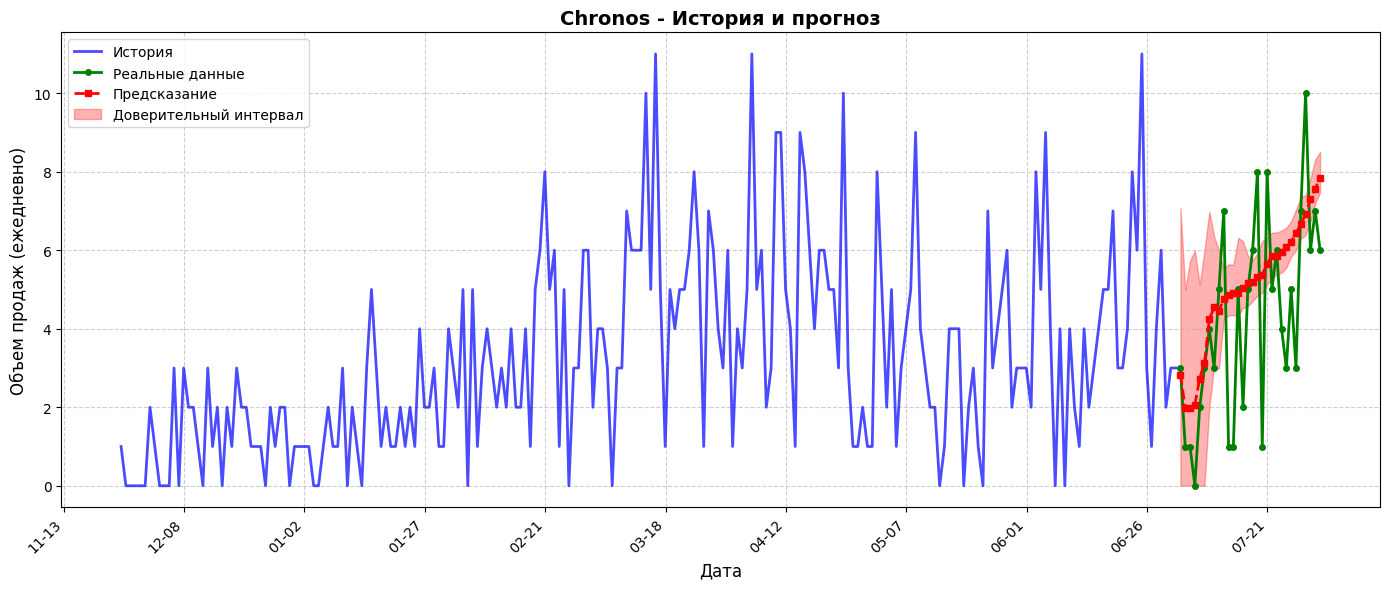

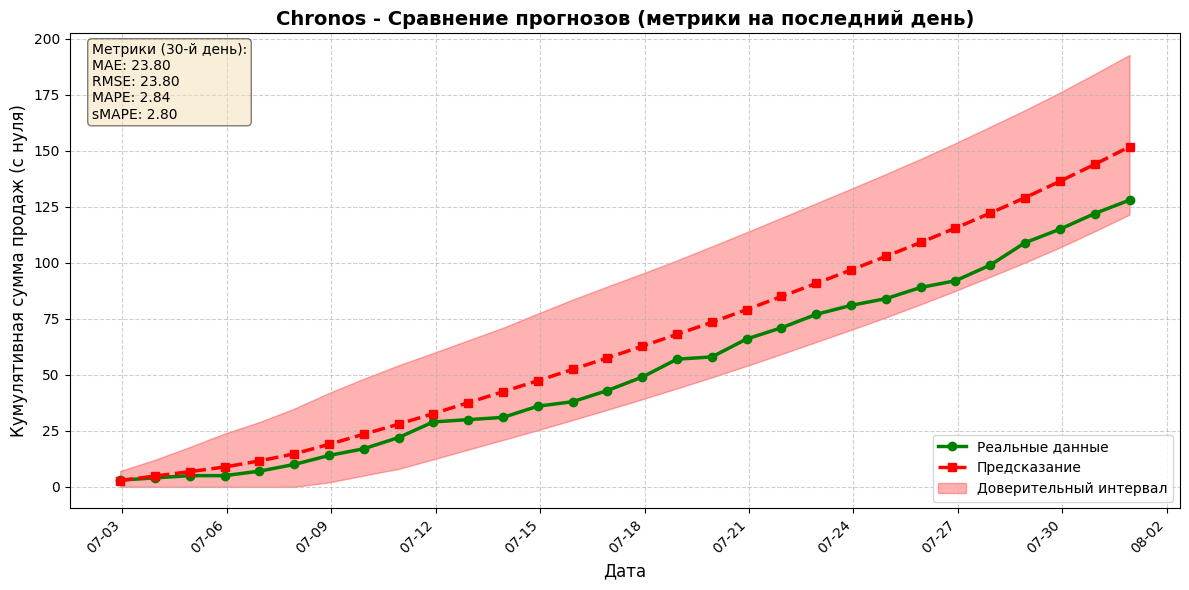

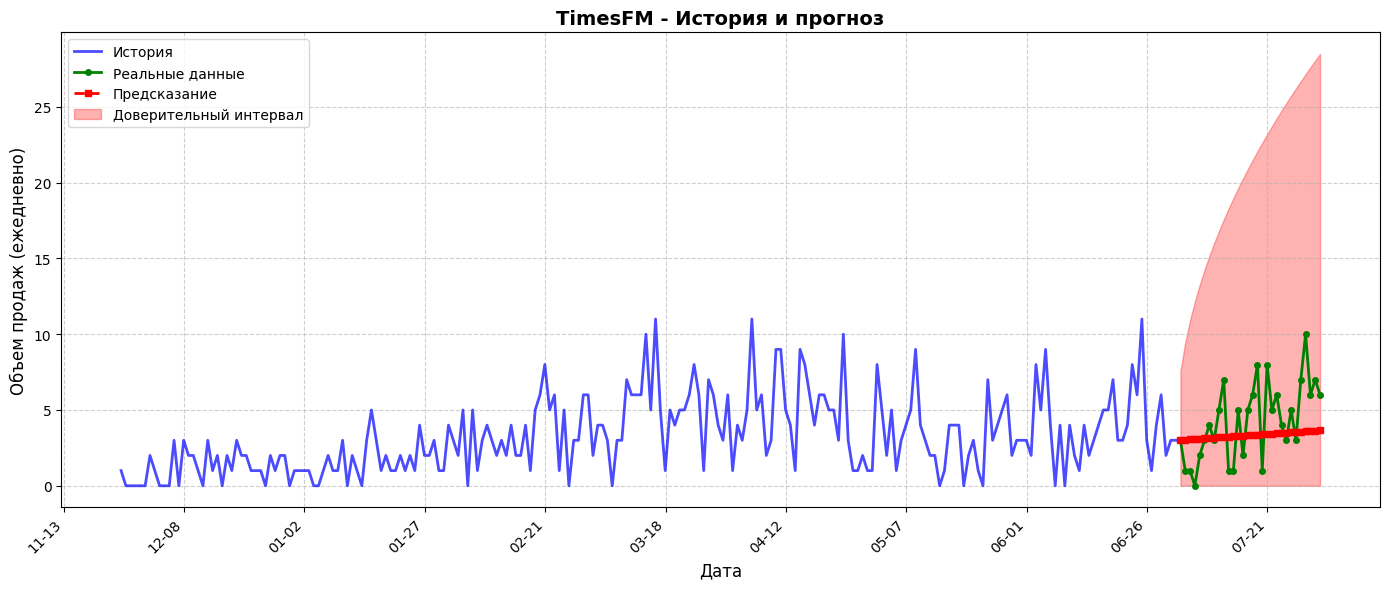

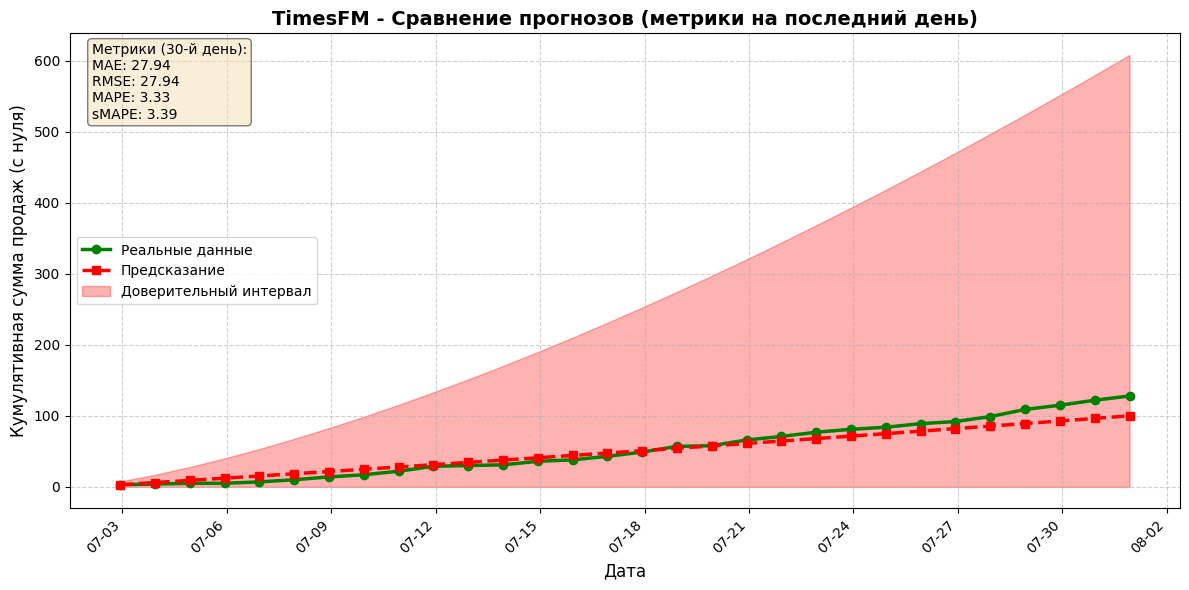

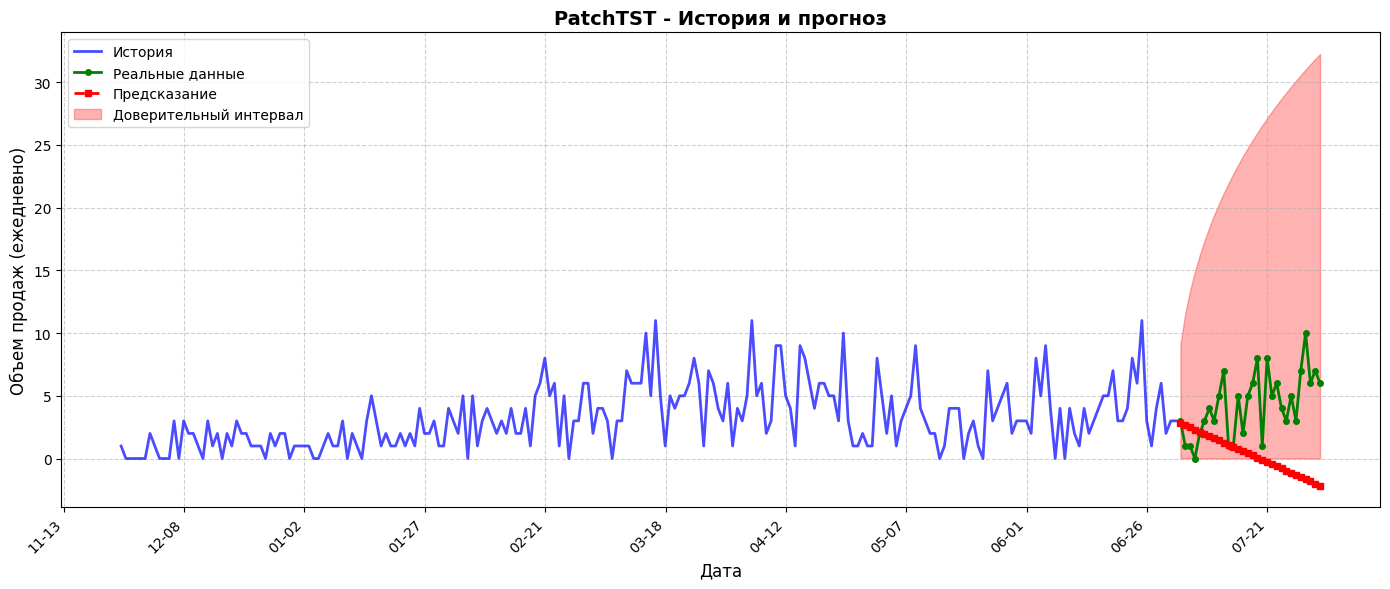

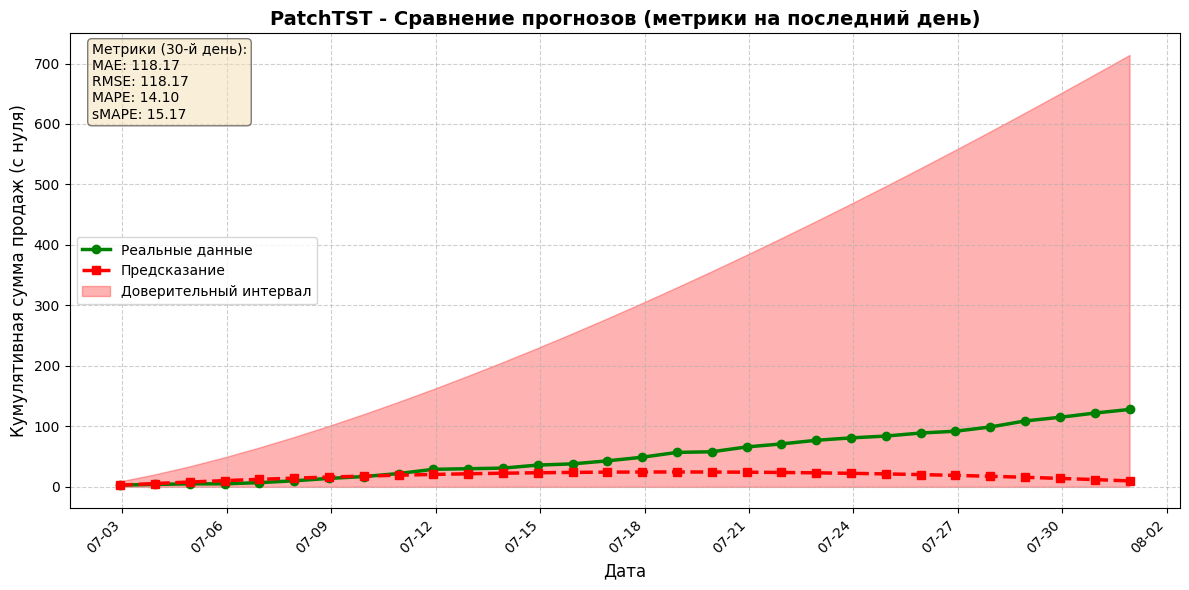

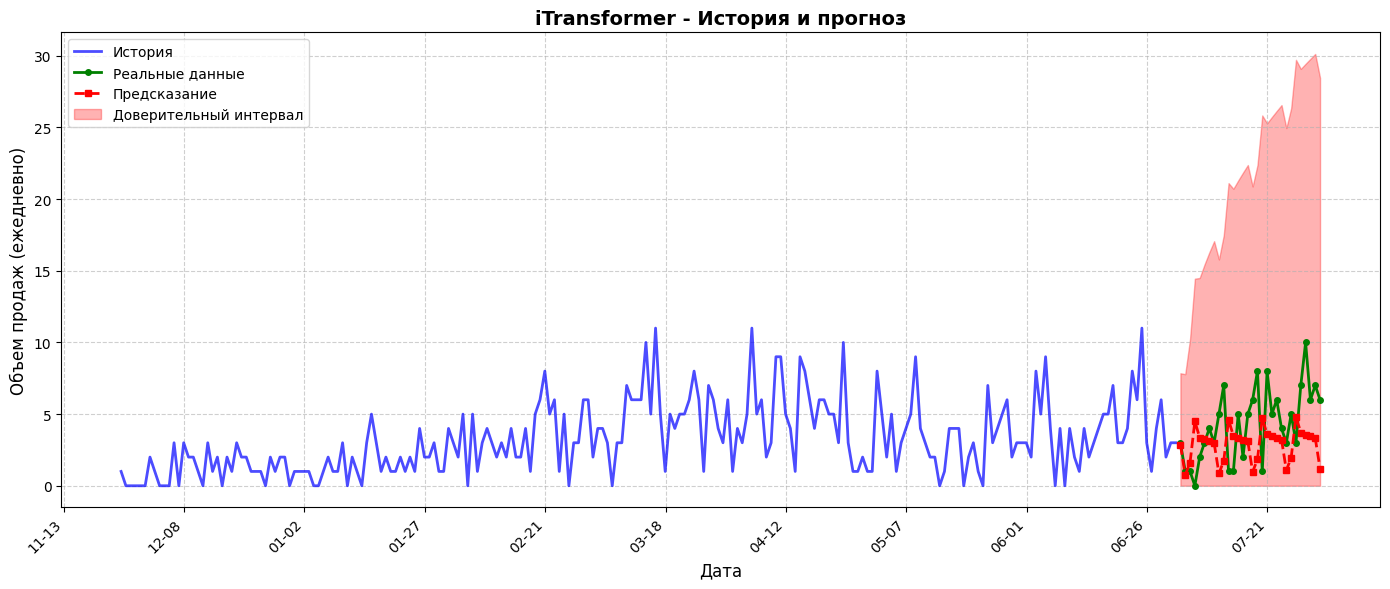

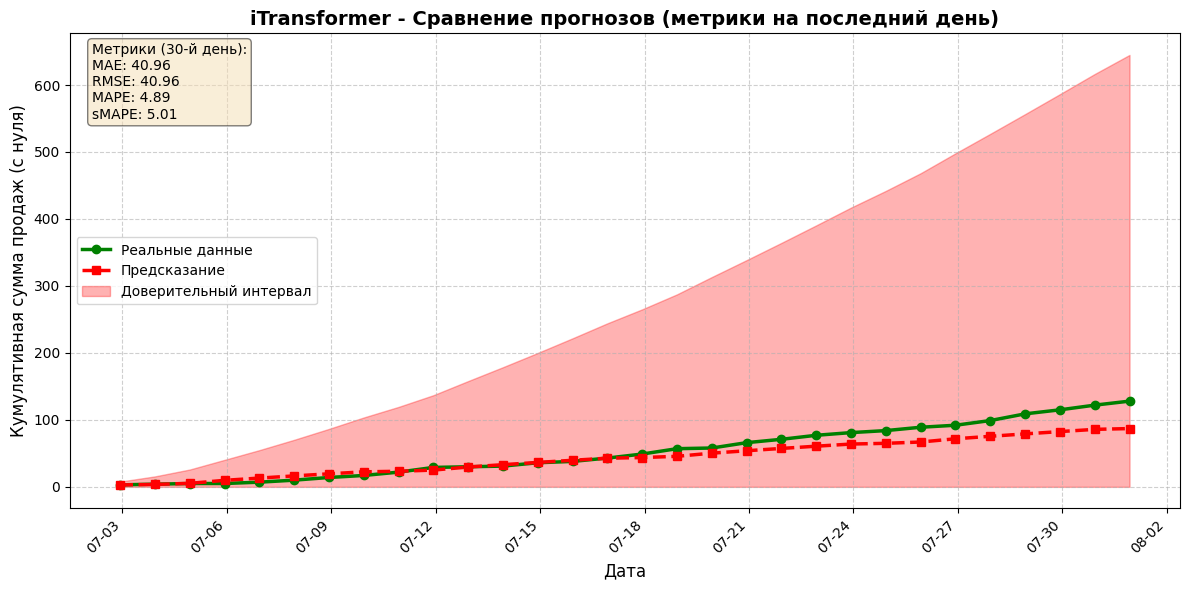

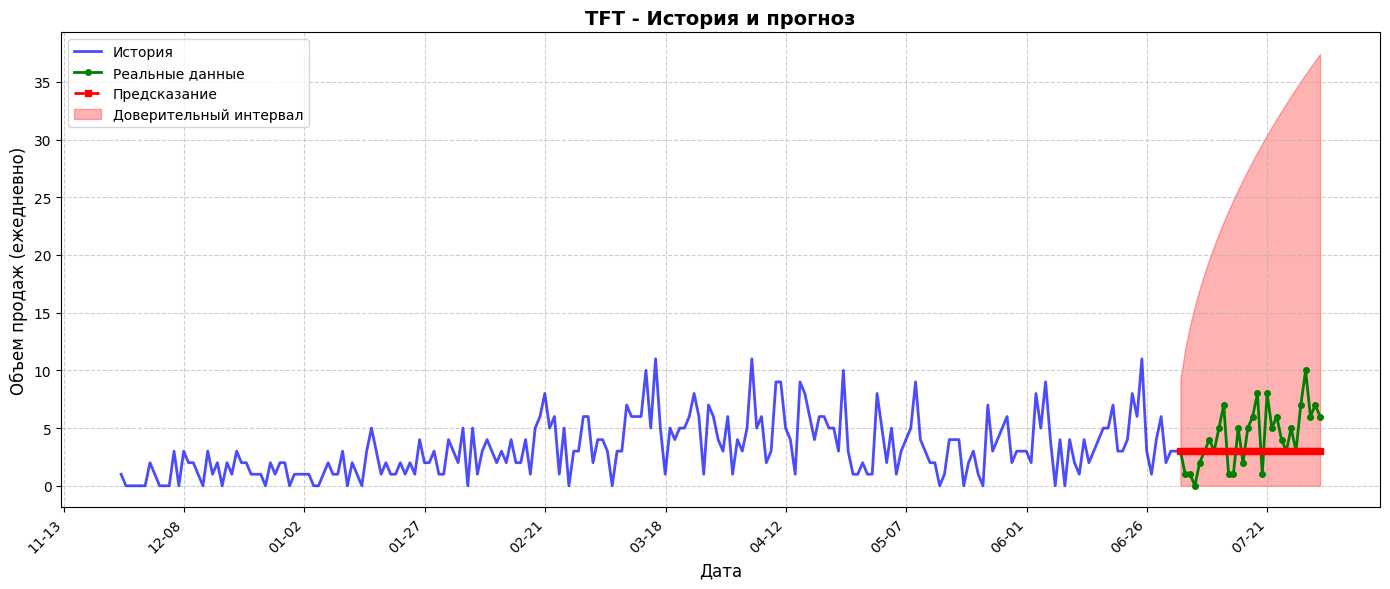

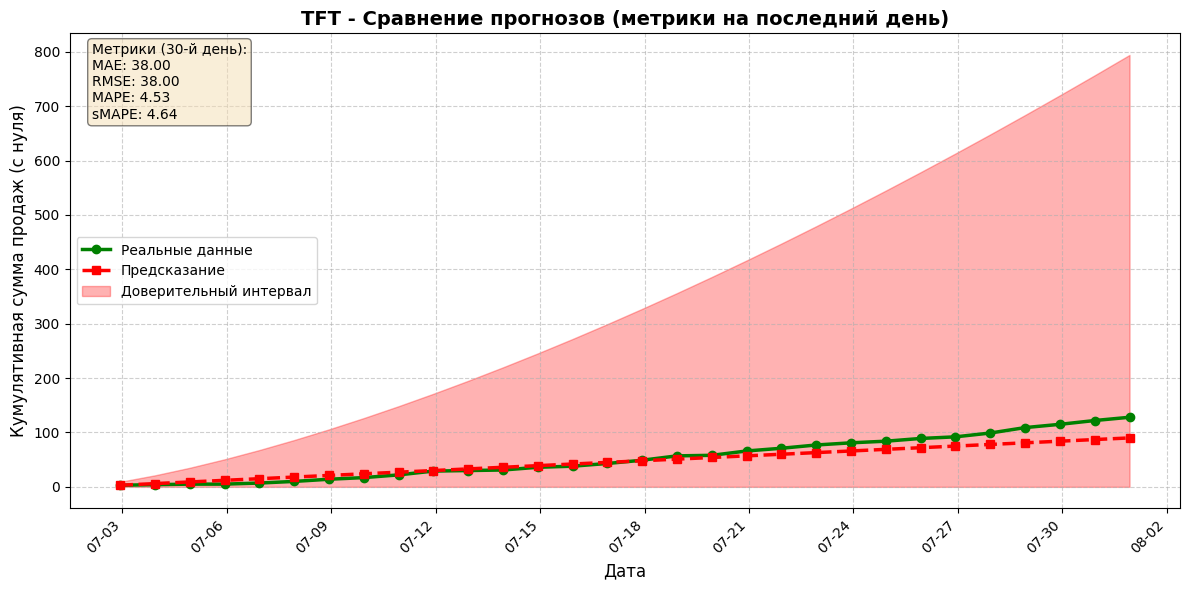

In [100]:
# Вычисляем дату начала прогноза
forecast_start_date = start_date + timedelta(days=len(train_data))

# Для первого графика используем исходные данные (ежедневные объемы)
# Модели возвращают кумулятивную сумму, нужно преобразовать обратно в ежедневные объемы
# Для этого вычислим приращения из кумулятивной суммы

# Создаем графики для каждого метода
for model_name in predictions.keys():
    lower, upper = confidence_intervals[model_name]
    
    # Преобразуем кумулятивную сумму прогноза обратно в ежедневные объемы
    # Для этого вычисляем приращения от начального значения
    pred_cumulative = predictions[model_name]
    pred_daily = np.diff(np.concatenate([[start_cumulative], pred_cumulative]))
    
    # Преобразуем доверительные интервалы
    if lower is not None and upper is not None:
        lower_daily = np.diff(np.concatenate([[start_cumulative], lower]))
        upper_daily = np.diff(np.concatenate([[start_cumulative], upper]))
    else:
        lower_daily, upper_daily = None, None
    
    # График 1: История (исходные данные) + прогноз (исходные данные, без кумулятивной суммы)
    fig1, ax1 = plot_single_method(
        historical_data=train_data,
        true_future=test_data,
        predicted=pred_daily,
        method_name=model_name,
        confidence_lower=lower_daily,
        confidence_upper=upper_daily,
        start_date=start_date,
        ylabel='Объем продаж (ежедневно)'
    )
    plt.show()
    
    # График 2: Только сравнение прогнозов - кумулятивная сумма, начиная с нуля
    # Преобразуем кумулятивную сумму так, чтобы она начиналась с нуля
    pred_cumulative_from_zero = pred_cumulative - start_cumulative
    test_cumulative_from_zero = test_data_cumulative - start_cumulative
    
    if lower is not None and upper is not None:
        lower_from_zero = lower - start_cumulative
        upper_from_zero = upper - start_cumulative
    else:
        lower_from_zero, upper_from_zero = None, None
    
    fig2, ax2 = plot_prediction_comparison(
        true_future=test_cumulative_from_zero,
        predicted=pred_cumulative_from_zero,
        method_name=model_name,
        metrics=metrics_dict[model_name],
        confidence_lower=lower_from_zero,
        confidence_upper=upper_from_zero,
        start_date=forecast_start_date,
        offset=0,
        ylabel='Кумулятивная сумма продаж (с нуля)'
    )
    plt.show()


### Итоговый график: сравнение всех методов



Усредненные метрики по всем методам (среднее значение метрик):
  MAE: 49.77
  RMSE: 49.77
  MAPE: 5.94
  sMAPE: 6.20

Метрики для усредненного предсказания (сравнение с реальными данными):
  MAE: 40.25
  RMSE: 40.25
  MAPE: 54.92
  sMAPE: 75.71
Отображаются 5 методов на итоговом графике: ['Chronos', 'TimesFM', 'PatchTST', 'iTransformer', 'TFT']


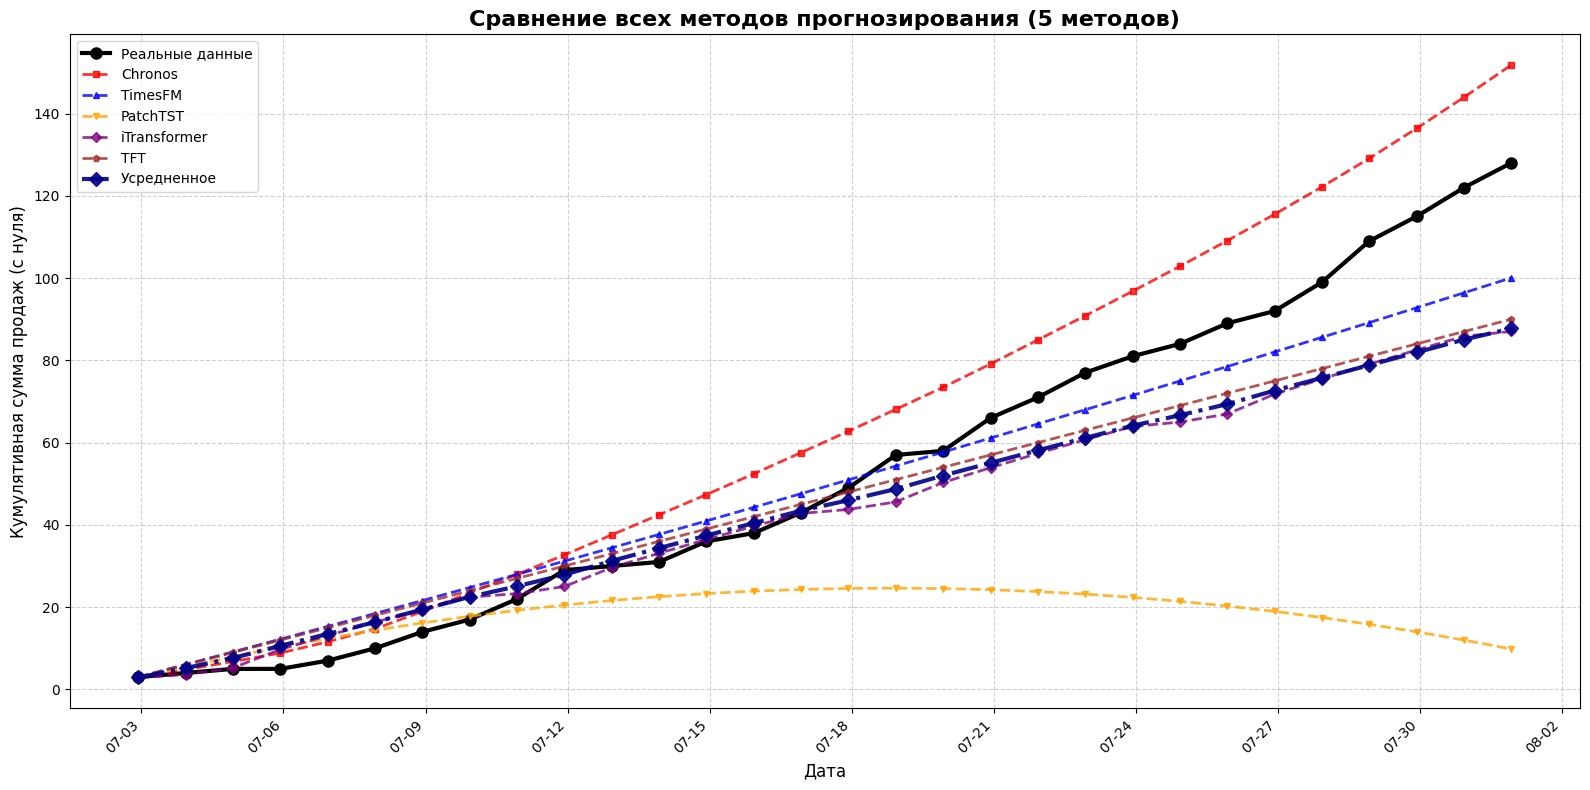

In [101]:
# Итоговый график со всеми методами (кумулятивная сумма, начиная с нуля)
# Преобразуем кумулятивные суммы так, чтобы они начинались с нуля
predictions_cumulative_from_zero = {}
for model_name, pred_cumulative in predictions.items():
    # Вычитаем начальное значение, чтобы начать с нуля
    pred_cumulative_from_zero = pred_cumulative - start_cumulative
    predictions_cumulative_from_zero[model_name] = pred_cumulative_from_zero

# Реальные данные тоже преобразуем, чтобы начинались с нуля
test_cumulative_from_zero = test_data_cumulative - start_cumulative

# Вычисляем усредненное предсказание по всем методам
# ВАЖНО: Усредняем ежедневные предсказания напрямую, а не кумулятивные суммы!
if len(predictions_daily) > 0:
    # Исключаем "Усредненное" если оно уже есть
    daily_for_averaging = {k: v for k, v in predictions_daily.items() if k != 'Усредненное'}
    all_daily_predictions = np.array(list(daily_for_averaging.values()))
    
    # Усредняем ежедневные предсказания напрямую
    averaged_daily = np.mean(all_daily_predictions, axis=0)
    
    # Преобразуем усредненные ежедневные предсказания в кумулятивную сумму
    averaged_cumulative = to_cumulative(averaged_daily, start_value=start_cumulative)
    averaged_cumulative_from_zero = averaged_cumulative - start_cumulative
    
    # Сохраняем для визуализации
    predictions_cumulative_from_zero['Усредненное'] = averaged_cumulative_from_zero
    
    # Вычисляем усредненные метрики (только по исходным методам, без "Усредненное")
    averaged_metrics = {}
    if len(metrics_dict) > 0:
        # Исключаем "Усредненное" из списка методов для усреднения
        methods_for_averaging = {k: v for k, v in metrics_dict.items() if k != 'Усредненное'}
        if len(methods_for_averaging) > 0:
            for metric_name in list(methods_for_averaging.values())[0].keys():
                metric_values = [metrics[metric_name] for metrics in methods_for_averaging.values()]
                averaged_metrics[metric_name] = np.mean(metric_values)
        
        # Вычисляем метрики для усредненного предсказания
        # Все метрики вычисляются правильно на соответствующих данных
        averaged_pred_metrics = {}
        
        # MAE и RMSE на кумулятивной сумме (с нуля)
        # MAE и RMSE на кумулятивной сумме (только последний день)
        averaged_pred_metrics['MAE'] = np.abs(test_cumulative_from_zero[-1] - averaged_cumulative_from_zero[-1])
        averaged_pred_metrics['RMSE'] = np.sqrt((test_cumulative_from_zero[-1] - averaged_cumulative_from_zero[-1]) ** 2)
        
        # MAPE и sMAPE на ежедневных объемах (правильное усреднение!)
        # MAPE и sMAPE на ежедневных объемах (только последний день)
        if np.abs(test_data[-1]) > 1e-8:
            averaged_pred_metrics['MAPE'] = np.abs((test_data[-1] - averaged_daily[-1]) / test_data[-1]) * 100
        else:
            averaged_pred_metrics['MAPE'] = np.nan
        denominator = (np.abs(test_data[-1]) + np.abs(averaged_daily[-1])) / 2
        if denominator > 1e-8:
            averaged_pred_metrics['sMAPE'] = np.abs(test_data[-1] - averaged_daily[-1]) / denominator * 100
        else:
            averaged_pred_metrics['sMAPE'] = np.nan
        
        metrics_dict['Усредненное'] = averaged_pred_metrics
        
        print("\n" + "=" * 60)
        print("Усредненные метрики по всем методам (среднее значение метрик):")
        print("=" * 60)
        for metric_name, metric_value in averaged_metrics.items():
            print(f"  {metric_name}: {metric_value:.2f}")
        print("\nМетрики для усредненного предсказания (сравнение с реальными данными):")
        for metric_name, metric_value in averaged_pred_metrics.items():
            print(f"  {metric_name}: {metric_value:.2f}")
        print("=" * 60)

fig, ax = plot_all_methods_comparison(
    true_future=test_cumulative_from_zero,
    predictions=predictions_cumulative_from_zero,
    start_date=forecast_start_date,
    offset=0,
    ylabel='Кумулятивная сумма продаж (с нуля)'
)
plt.show()


### Сводная таблица метрик


In [102]:
# Создаем сводную таблицу метрик (без усредненного)
import pandas as pd

# Исключаем "Усредненное" из таблицы метрик
metrics_for_table = {k: v for k, v in metrics_dict.items() if k != 'Усредненное'}
metrics_df = pd.DataFrame(metrics_for_table).T
metrics_df = metrics_df.round(2)

print("\nСводная таблица метрик:")
print("=" * 60)
print(metrics_df.to_string())
print("=" * 60)



Сводная таблица метрик:
                 MAE    RMSE   MAPE  sMAPE
Chronos        23.80   23.80   2.84   2.80
TimesFM        27.94   27.94   3.33   3.39
PatchTST      118.17  118.17  14.10  15.17
iTransformer   40.96   40.96   4.89   5.01
TFT            38.00   38.00   4.53   4.64
